In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os
import glob
import wget
import tqdm

from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
import astropy.units as u

import shapely.geometry

from astropy.io import fits
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import Cutout2D, block_reduce
from astropy.table import Table, join
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize, AsinhStretch, LogStretch, ManualInterval
from astropy.stats import sigma_clip
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel,Tophat2DKernel, convolve

from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp

In [2]:
df = pd.read_csv('C:/Users/oryan/Documents/zoobot_new/manifests/gz-hubble-local-manifest.csv',index_col=0)

In [3]:
df.query('zooniverse_id == "AHZ2000aaq"')

,zooniverse_id,RA,Dec,imaging,interacting,local_location
21612,AHZ2000aaq,150.43033,1.86137,COSMOS,1,C:/Users/oryan/Documents/zoobot/hubble-dataset...


In [4]:
test_row = df.iloc[0]
ra = test_row['RA']
dec = test_row['Dec']
zooniverse_id = test_row['zooniverse_id']
local_location = test_row['local_location']

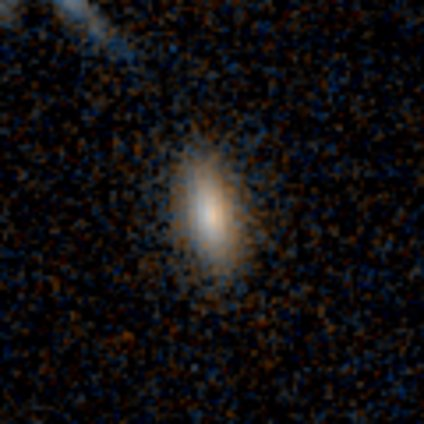

In [5]:
Image.open(local_location)

In [6]:
test_row

zooniverse_id                                            AHZ10004js
RA                                                          215.001
Dec                                                         52.9554
imaging                                                       AEGIS
interacting                                                       1
local_location    C:/Users/oryan/Documents/zoobot/hubble-dataset...
Name: 5895, dtype: object

In [7]:
coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame='fk5')

In [8]:
obs_table = Observations.query_criteria(
    coordinates = coord,
    radius = 20 * u.arcsec,
    dataproduct_type='image',
    obs_collection = 'HLA',
    calib_level = 3,
    type='S',
    filters = ['F814W']
)

In [129]:
parent_obs = pd.DataFrame(obs_table.to_pandas().obsid.value_counts()).reset_index().rename(columns={'index':'parent_obsid'}).drop(columns='obsid')

In [130]:
parent_obs

,parent_obsid
0,25793317


In [131]:
obs_table.to_pandas()[['obsid','dataURL','t_obs_release']].sort_values('t_obs_release',ascending=False)

,obsid,dataURL,t_obs_release
0,25793317,https://hla.stsci.edu/cgi-bin/getdata.cgi?data...,53081.615984


In [132]:
wanted_obs = Table.from_pandas(obs_table.to_pandas().sort_values('t_obs_release',ascending=False))

In [133]:
data_products = Observations.get_product_list(wanted_obs)

In [134]:
download_products = Table.from_pandas(
    data_products
    .to_pandas()
    .query('dataproduct_type == "image"')
    .query('obs_collection == "HLA"')
    .query('type == "C"')
    .query('calib_level == 3')
    .query('productType == "SCIENCE"')
    .merge(parent_obs,on='parent_obsid',how='right')
    .dropna(0,thresh=5)
)

In [135]:
download_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str25,str29,str1,str75,str7,str28,str3,bytes1,str3,bytes1,str4,str34,object,str8,str6,int64
25793317,HLA,image,hst_9822_22_acs_wfc_f814w,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_9822_22_acs_wfc_f814w_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,9822,hst_9822_22_acs_wfc_f814w_drz.fits,400944960,25793317,PUBLIC,3


In [136]:
if os.path.exists(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/'):
    pass
else:
    os.mkdir(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/')

In [137]:
n_download = len(wanted_obs)
print(n_download)

1


In [138]:
manifest = Observations.download_products(download_products[:3],download_dir = f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}')

In [139]:
tmp = glob.glob(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/*.fits')
if type(tmp) != list:
    files = [tmp]
else:
    files = tmp

In [140]:
files

[]

In [202]:
files = [manifest['Local Path'][0]]

In [200]:
file = files[0]
headers = fits.open(file)[1].header
data = fits.open(file)[1].data
wcs_out = wcs.WCS(headers)

In [177]:
coord

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (150.4303304, 1.8613697)>

In [144]:
#coord = SkyCoord(ra = 215.0013967 * u.deg, dec = 52.9553995 * u.deg, frame='fk5')

In [203]:
cutout = Cutout2D(data,coord,(300,300),wcs=wcs_out,mode='strict')

In [204]:
coord

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (150.4303304, 1.8613697)>

In [205]:
print(len(cutout.data[cutout.data == 0.0]))

0


In [206]:
cutout.data[cutout.data == 0] = np.min(data)

In [207]:
print(np.max(data))
print(np.min(data))

117.40202
0.0


In [208]:
print(np.max(cutout.data))
print(np.min(cutout.data))

5.4189796
0.052005418


In [209]:
pixels = skycoord_to_pixel(coord,wcs=wcs_out)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


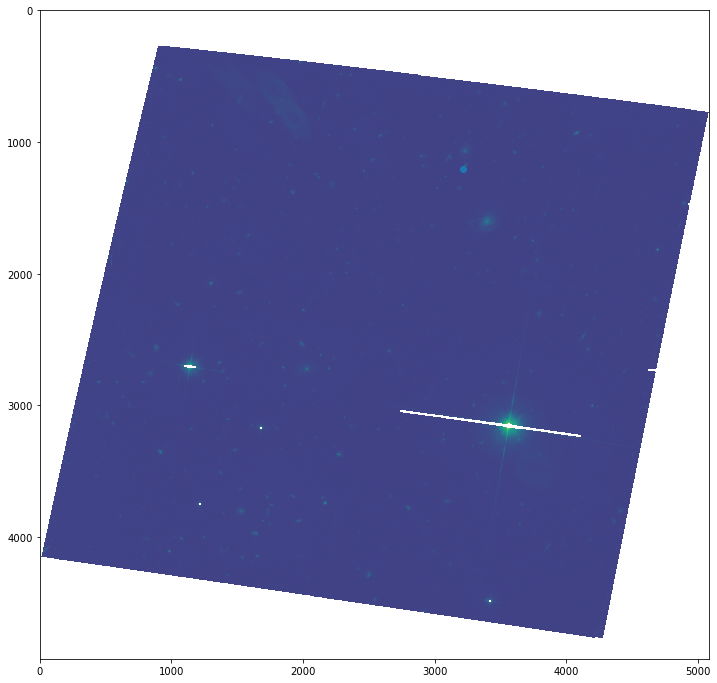

In [210]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(data))
plt.scatter(pixels[0],pixels[1])

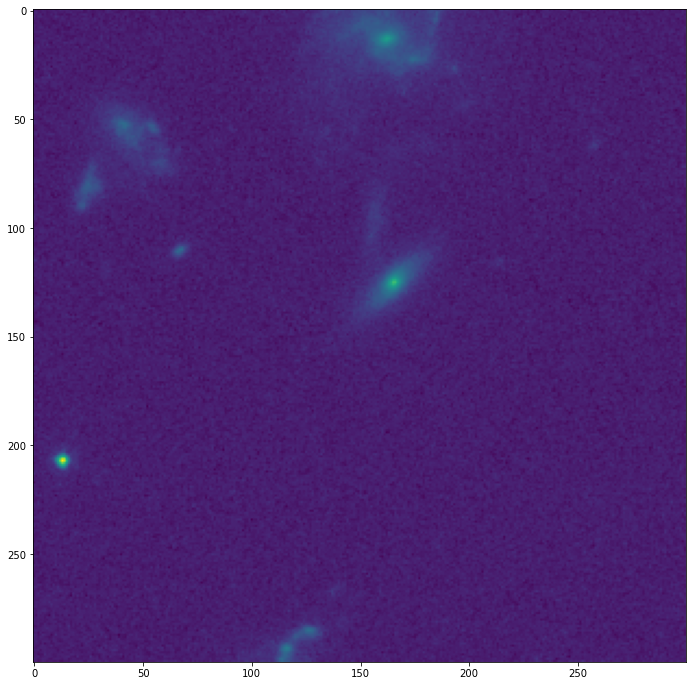

In [211]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(cutout.data))

In [212]:
norm = ImageNormalize(cutout.data,interval=ZScaleInterval(nsamples=7500,contrast=0.05),stretch=LinearStretch(),clip=True)

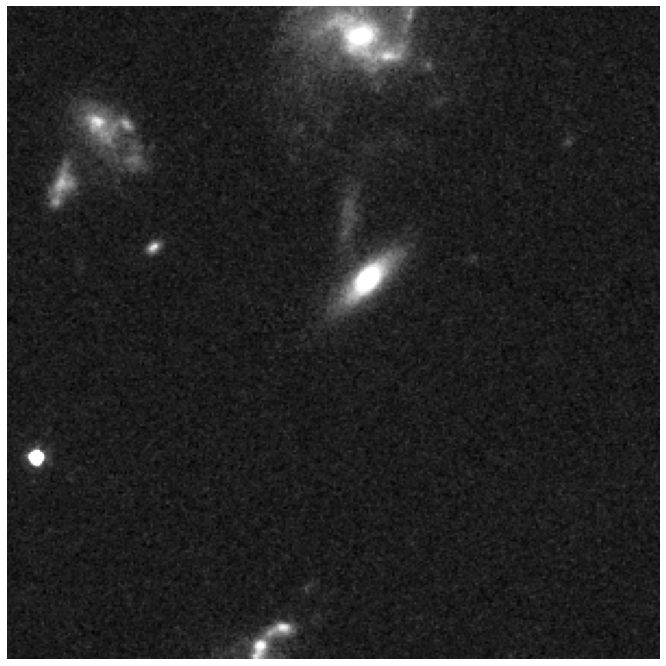

In [213]:
plt.figure(figsize=(12,12))
plt.imshow(cutout.data,cmap='Greys_r',norm=norm)
plt.axis('off')
plt.savefig(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/{zooniverse_id}.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [159]:
im = Image.open(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/{zooniverse_id}.png')

In [160]:
im_grey = ImageOps.grayscale(im)

In [161]:
im_grey.thumbnail([300,300])

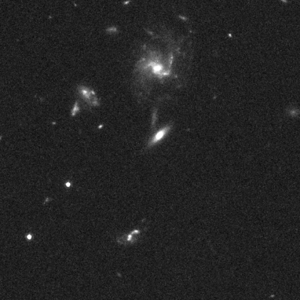

In [162]:
im_grey

In [163]:
im_grey.save(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/{zooniverse_id}_{np.asarray(im_grey).shape[0]}_{np.asarray(im_grey).shape[1]}.png')